In [1]:
from coagulation_model.coagulation_kernel import CoagulationKernel as kernel
from coagulation_model.sectional_mass_changes import SectionalMassChanges
from coagulation_model.sectional_coagulation_kernels import SectionalCoagulationKernels
from coagulation_model.particle_size_distribution import ParticleSizeDistribution as psd

from coagulation_model.plotting_kernels import plot_kernel_map
from coagulation_model.plotting_kernels import plot_normalized_kernel_map
from coagulation_model.plotting_kernels import plot_kernel_diff_map
from coagulation_model.plotting_kernels import plot_sectional_kernels
from coagulation_model.plotting_kernels import plot_particlesize_classes

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('notebook')

## Comparing sectional mass changes

### matlab results

In [2]:
matlab_particle_size_distribution = np.array([0.6283e-05, 0.0628e-05, 0.0063e-05, 0.0006e-05, 0.0001e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05])
dvdt = np.array([-0.2244e-05, 0.0984e-05, 0.1037e-05, 0.0192e-05, 0.0027e-05, 0.0003e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05])

In [3]:
particle_size_distribution = psd(radius_sphere_min = 1e-6,radius_sphere_max = 1.1e-4,
                                 type='powerlaw',kwargs={'a':2e-12,'k':4})

In [5]:
particle_size_distribution.data.shape

(20,)

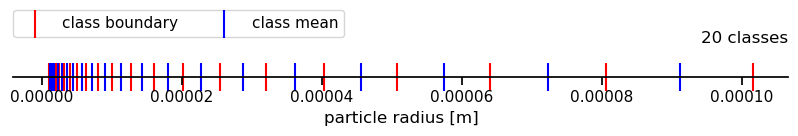

In [6]:
# volume of each size class 
volume_boundary_spheres = particle_size_distribution.radius_boundary_spheres**3
volume_mean_spheres = particle_size_distribution.radius_mean_spheres**3

# plot the volume on a number line
plot_particlesize_classes(particle_size_distribution.radius_boundary_spheres)



In [7]:
coagulation_kernel = kernel(
    list_of_applied_kernels=[
        # 'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_jackson_lochmann_fractal'
    )

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Radius of particle i (m)', ylabel='Radius of particle j (m)'>)

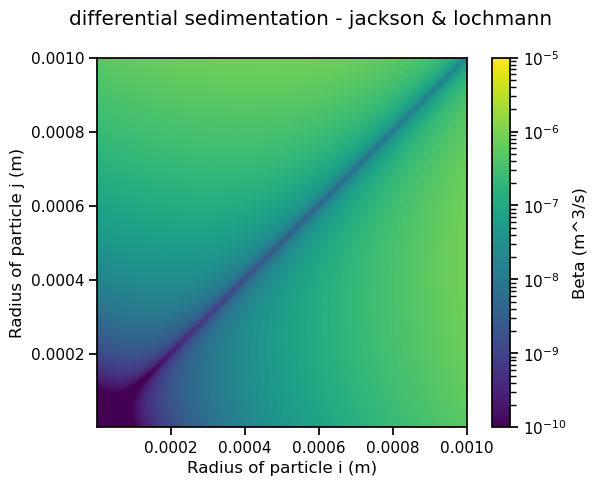

In [8]:

plot_kernel_map(coagulation_kernel, 'differential sedimentation - jackson & lochmann', norm_range = [1e-10, 1e-5], scale='lin')


In [9]:

sectional_kernel = SectionalCoagulationKernels(coagulation_kernel,particle_size_distribution)
sectional_kernel.eval_all_kernels()


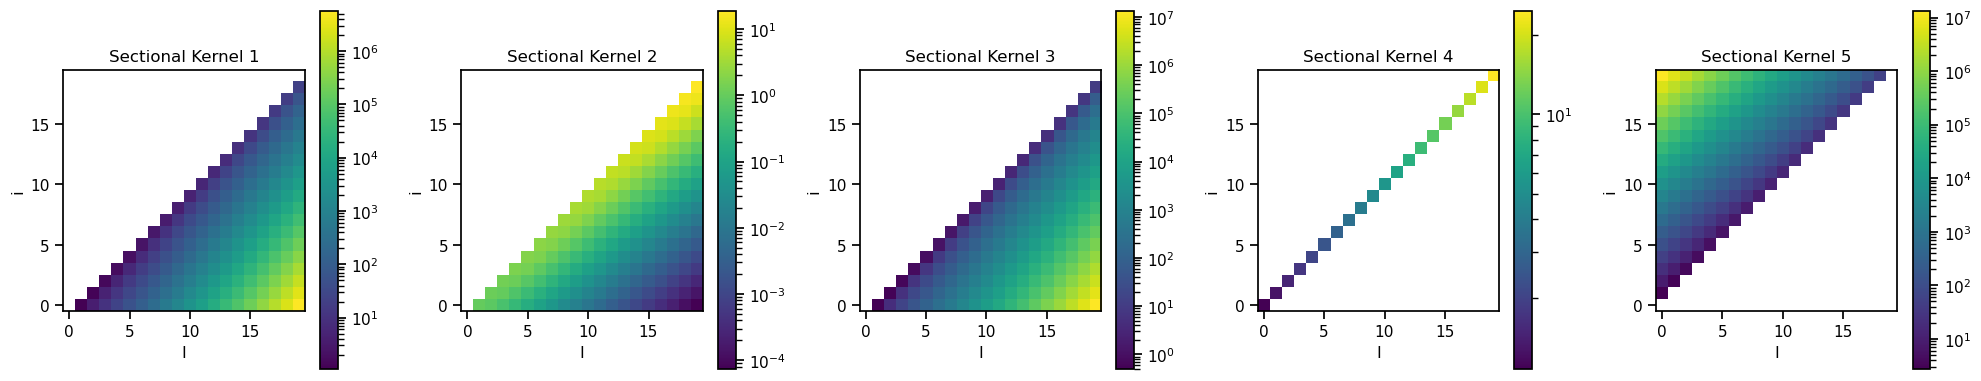

In [10]:
fig,ax = plot_sectional_kernels(sectional_kernel.data)

In [11]:
def read_beta_files(num_files, directory="coag_model_adrian_matlab"):
    """
    Read beta_i.txt files into a 3D numpy array.
    
    Args:
        num_files (int): Number of beta files to read (beta_1.txt to beta_n.txt)
        directory (str): Directory containing the beta files
        
    Returns:
        numpy.ndarray: 3D array of shape (num_files, 20, 20) containing all beta matrices
    """
    # Initialize 3D array to store all beta matrices
    beta_matrices = np.zeros((num_files, 20, 20))
    
    # Read each beta file
    for i in range(num_files):
        file_path = f"{directory}/beta_{i+1}.txt"
        try:
            beta_matrices[i] = np.loadtxt(file_path,delimiter=',')
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            
    return beta_matrices

matlab_betas = read_beta_files(5)

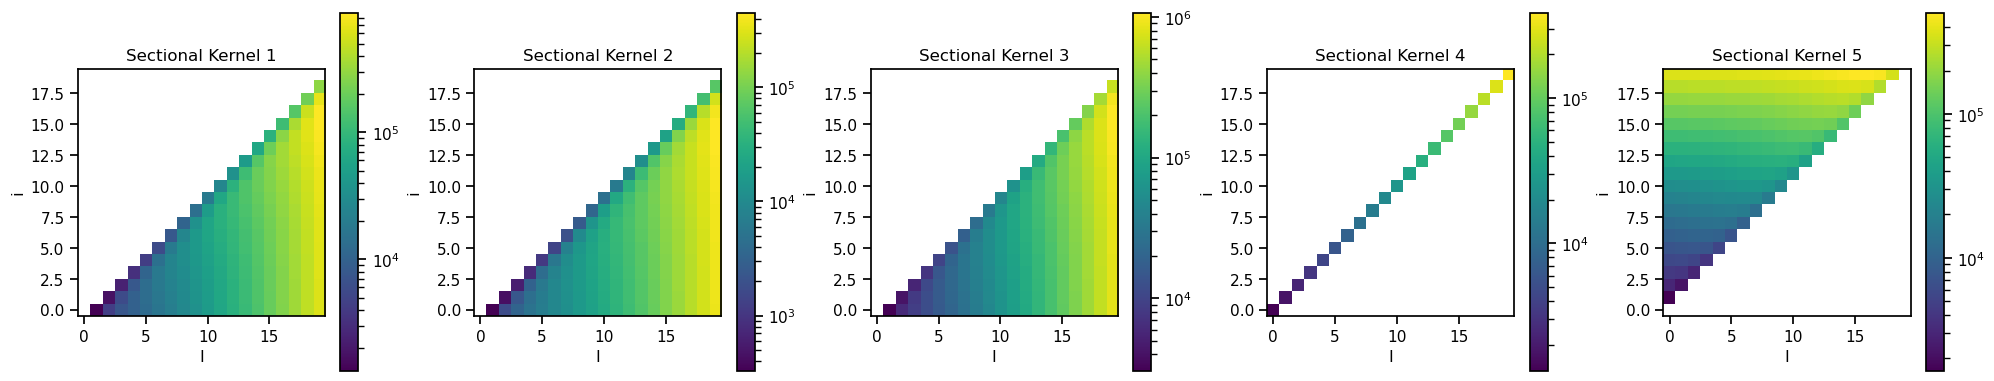

In [12]:
fig, ax = plot_sectional_kernels(matlab_betas*1e6)

### Particle size distribution 

In [13]:
matlab_particle_size_distribution.shape

(20,)

In [14]:
# here we compare it to the "original" results from the matlab code
# to do so we make sure that we use the same initial particle size distribution
particle_size_distribution.data = matlab_particle_size_distribution

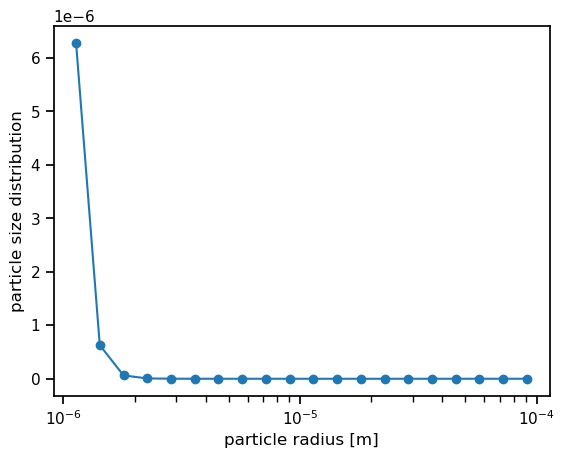

In [15]:
# plot particle size distribution
fig,ax = plt.subplots()
ax.plot(particle_size_distribution.radius_mean_spheres,particle_size_distribution.data, marker='o')
ax.set_xscale('log')
ax.set_xlabel('particle radius [m]')
ax.set_ylabel('particle size distribution')
plt.show()

### Sectional mass changes

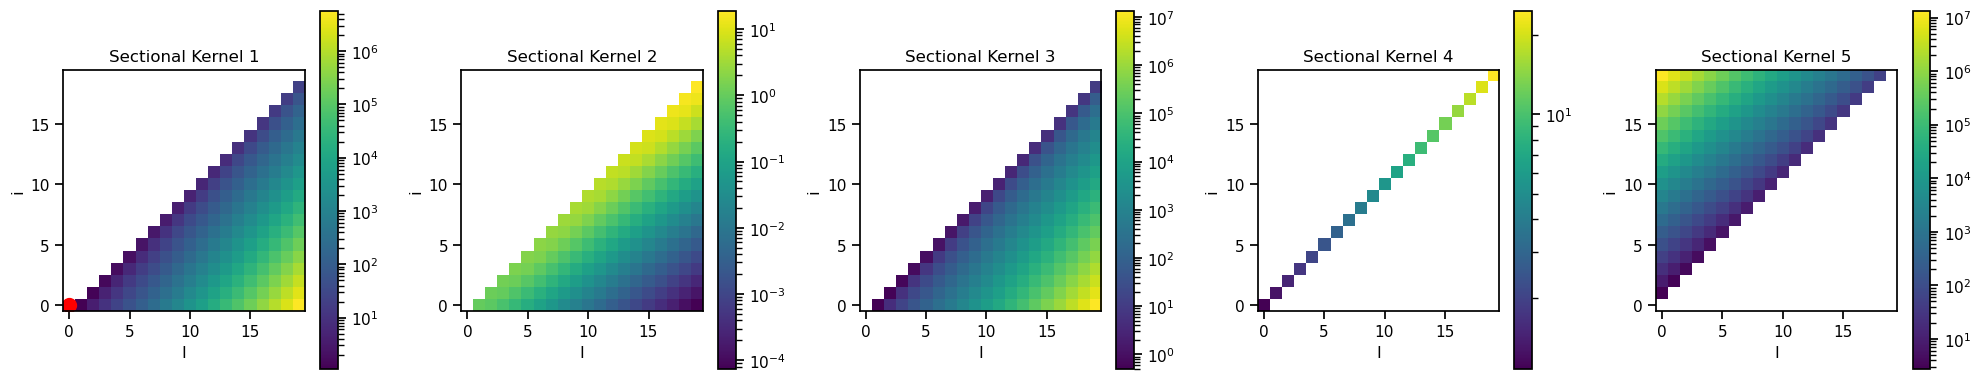

In [16]:
# sectional_kernel.data = matlab_betas

fig, ax = plot_sectional_kernels(sectional_kernel.data)
# Add a red dot at position (2,3)
ax[0].plot(0, 0, 'ro', markersize=10)  # Note: imshow uses (row,col) indexing

In [17]:

sectional_mass_changes = SectionalMassChanges(sectional_kernel,particle_size_distribution)
sectional_mass_changes.calculate_mass_changes()

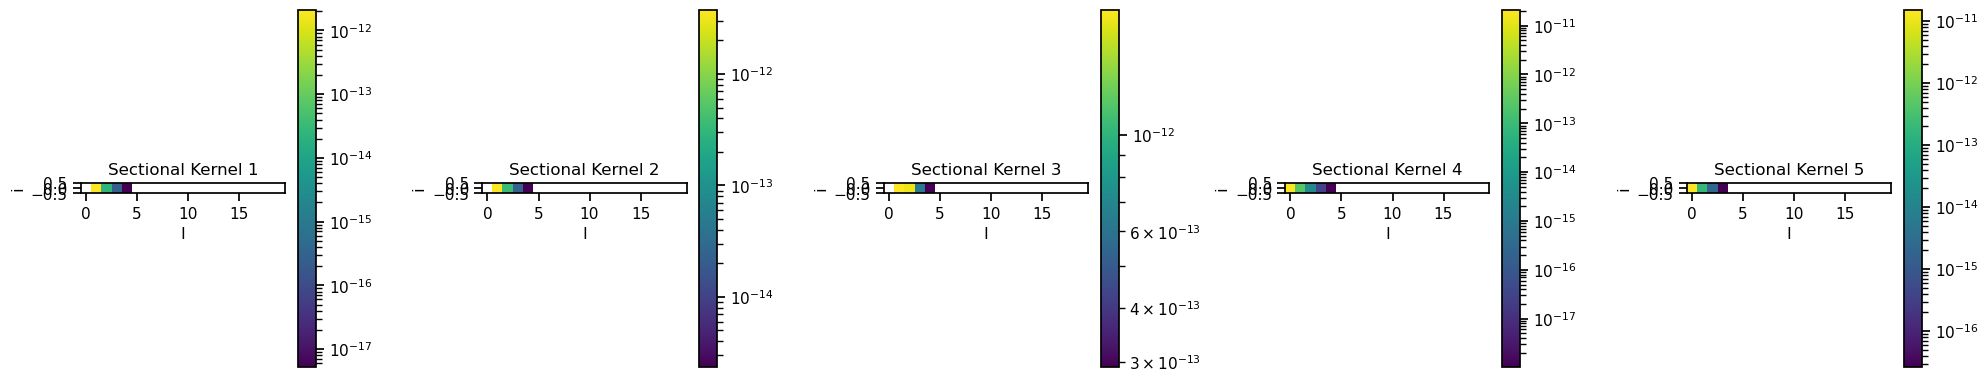

In [18]:
fig, ax = plot_sectional_kernels(sectional_mass_changes.components[:,:])

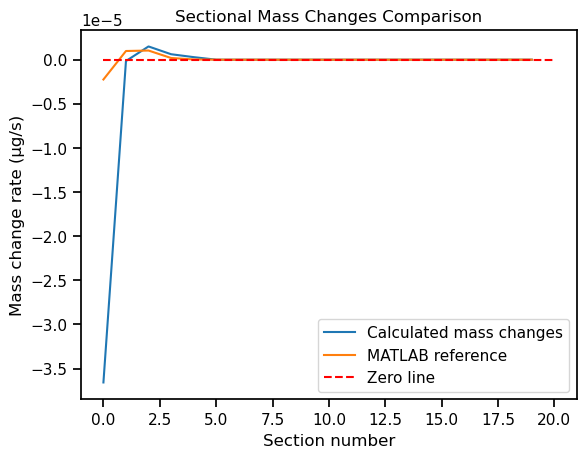

In [52]:
fig, ax = plt.subplots()
ax.plot(sectional_mass_changes.data*1z e6, label='Calculated mass changes')
ax.plot(dvdt, label='MATLAB reference')
ax.hlines(0, 0, 20, linestyles='dashed', colors='r', label='Zero line')

ax.set_xlabel('Section number')
ax.set_ylabel('Mass change rate (μg/s)')
ax.set_title('Sectional Mass Changes Comparison')
ax.legend()
plt.show()

## Looking at Kriest kernels

In [ ]:
default_kernel = kernel(
    list_of_applied_kernels=[
        'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_jackson_lochmann_fractal'
    )

kries_dense_kernel = kernel(
    list_of_applied_kernels=[
        'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_kriest_dense_aggregate'
    )

kries_porous_kernel = kernel(
    list_of_applied_kernels=[
        'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_kriest_porous_aggregate'
    )

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Radius of particle i (m)', ylabel='Radius of particle j (m)'>)

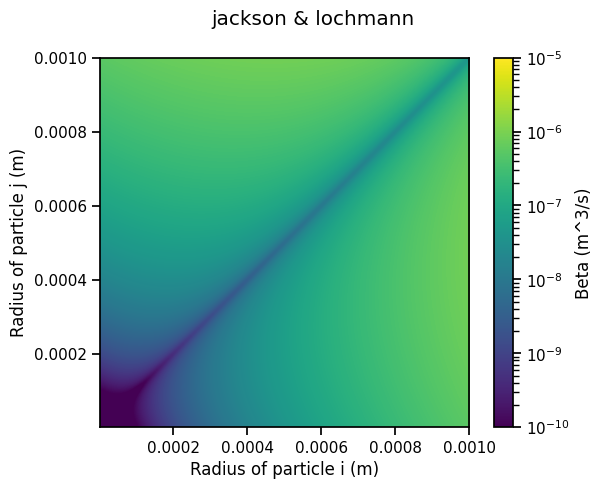

In [ ]:
plot_kernel_map(default_kernel, 'jackson & lochmann', norm_range = [1e-10, 1e-5], scale='lin')

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Radius of particle i (m)', ylabel='Radius of particle j (m)'>)

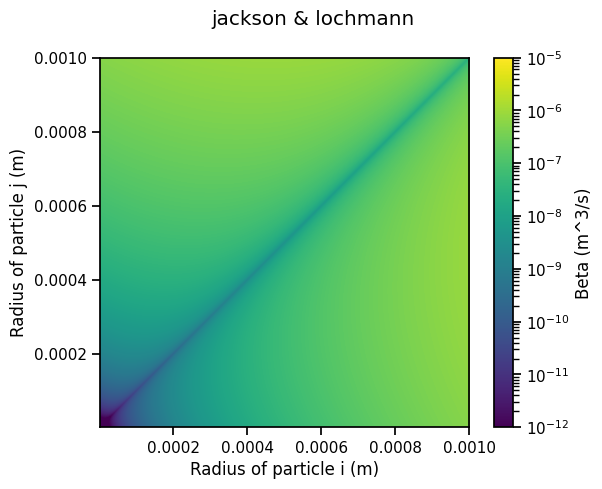

In [ ]:
plot_kernel_map(default_kernel, 'jackson & lochmann',
                norm_range = [1e-12, 1e-5], 
                n=500,
                r_min=1e-6, r_max=1e-3,
                scale='lin')

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Radius of particle i (m)', ylabel='Radius of particle j (m)'>)

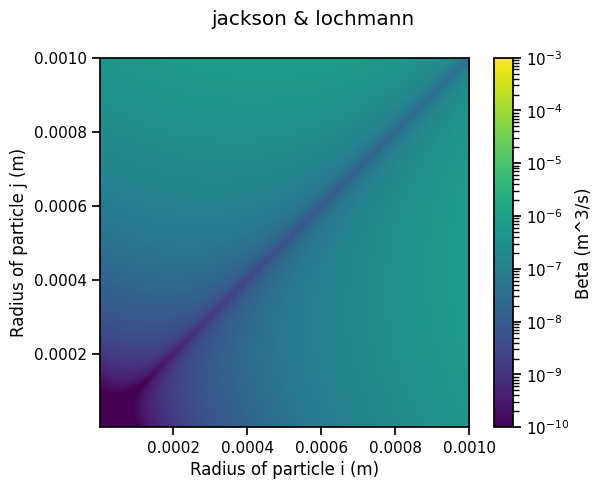

In [ ]:
plot_kernel_map(default_kernel, 'jackson & lochmann', norm_range = [1e-10, 1e-3], scale='lin')

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Radius of particle i (m)', ylabel='Radius of particle j (m)'>)

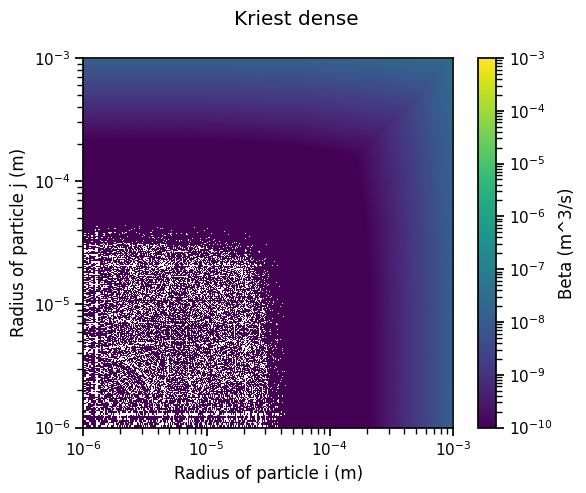

In [ ]:
plot_kernel_map(kries_dense_kernel, 'Kriest dense', norm_range = [1e-10, 1e-3])

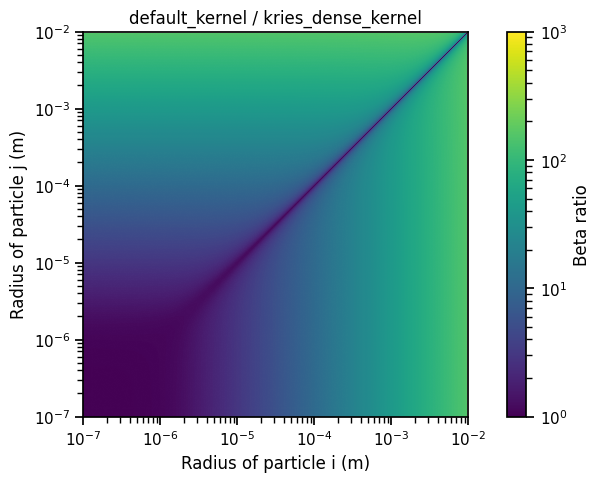

In [ ]:
plot_normalized_kernel_map(
    default_kernel, 'default_kernel', 
    kries_dense_kernel, 'kries_dense_kernel',
    n=10000,
    r_min=1e-7, r_max=1e-2,
    norm_range=[1e0, 1e3],
    save_path='kernel_map_kries_dense_vs_default.png'
)

In [ ]:
# 1e-5cm in m
    

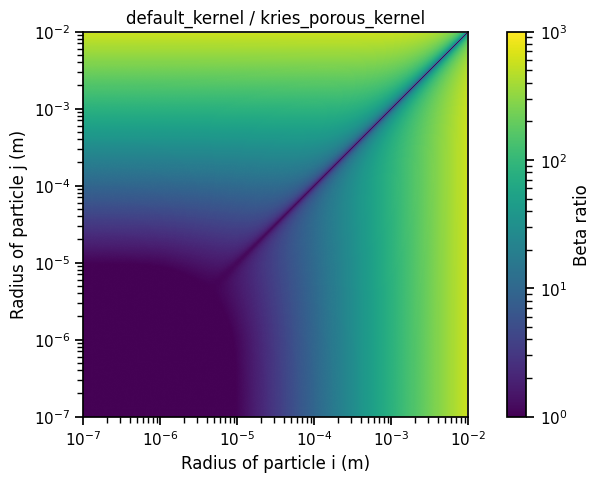

In [ ]:
plot_normalized_kernel_map(
    default_kernel, 'default_kernel', 
    kries_porous_kernel, 'kries_porous_kernel',
    r_min=1e-7, r_max=1e-2,
    norm_range=[1e0, 1e3],
    n = 10000,	
    save_path='kernel_map_kries_porous_vs_default.png'
)

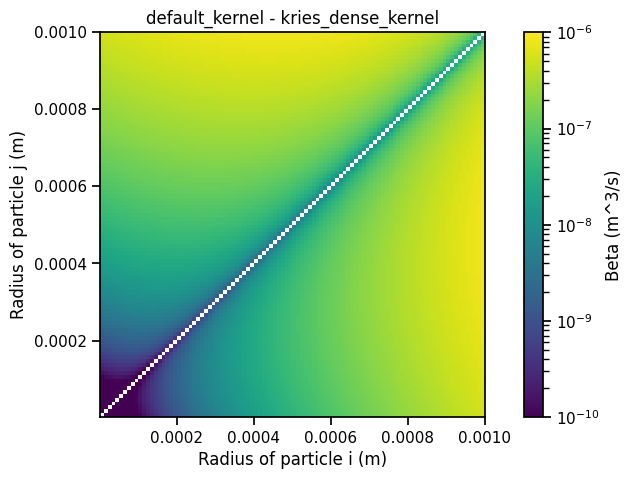

In [ ]:
plot_kernel_diff_map(
    default_kernel, 'default_kernel', 
    kries_dense_kernel, 'kries_dense_kernel',
    r_min=1e-6, r_max=1e-3,
    norm_range=[1e-10, 1e-6]
)

## Looking at kernel slices to validate Jackson & Lochmann kernel with Adrians Paper

In [2]:
kriest_dense_kernel = kernel(
    list_of_applied_kernels=[
        # 'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_kriest_dense_aggregate'
    )

kriest_porous_kernel = kernel(
    list_of_applied_kernels=[
        # 'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_kriest_porous_aggregate'
    )


jackson_lochmann_kernel = kernel(
    list_of_applied_kernels=[
        # 'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_jackson_lochmann_fractal'
    )

In [5]:
betas_jackson

array([4.49221480e-05, 4.54887123e-05, 4.62178690e-05, ...,
       3.29984455e+05, 3.30125916e+05, 3.30267423e+05])

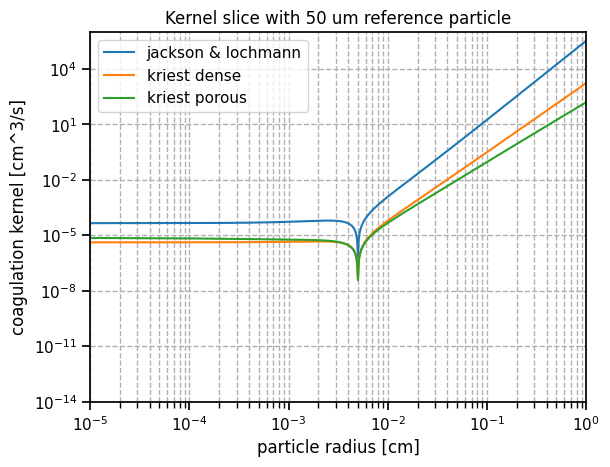

In [4]:
r_reference = 50e-6
r_test = np.linspace(1e-7,1e-2,10000)

betas_jackson = jackson_lochmann_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_jackson = betas_jackson*1e6 # cm^3/s
betas_kriest_dense = kriest_dense_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_kriest_dense = betas_kriest_dense*1e6 # cm^3/s
betas_kriest_porous = kriest_porous_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_kriest_porous = betas_kriest_porous*1e6 # cm^3/s


plt.xscale('log')
plt.yscale('log')

plt.plot(r_test*100,betas_jackson, label='jackson & lochmann')
plt.plot(r_test*100,betas_kriest_dense, label='kriest dense')
plt.plot(r_test*100,betas_kriest_porous, label='kriest porous')

plt.xlabel('particle radius [cm]')   
plt.ylabel('coagulation kernel [cm^3/s]')
plt.title('Kernel slice with 50 um reference particle')
plt.ylim([1e-14,1e6])
plt.xlim([1e-5,1e0])
# set scaling to log


plt.legend()

plt.grid(which='both',linestyle='--')
# add minor along y axis
plt.minorticks_on()

plt.savefig('kernel_slices_default_vs_kriest_50um.png')

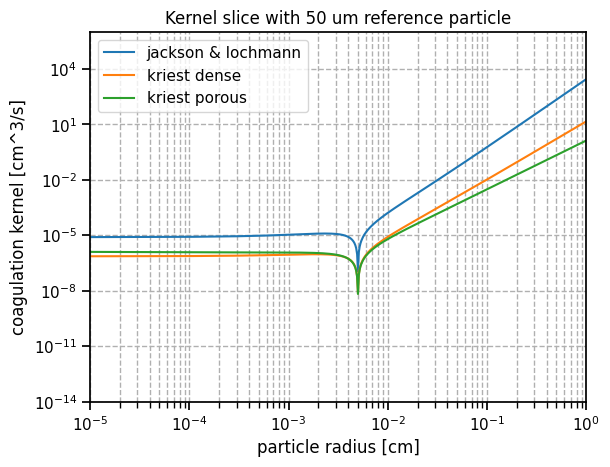

In [4]:
r_reference = 50e-6
r_test = np.linspace(1e-7,1e-2,10000)

betas_jackson = jackson_lochmann_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_jackson = betas_jackson*1e6 # cm^3/s
betas_kriest_dense = kriest_dense_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_kriest_dense = betas_kriest_dense*1e6 # cm^3/s
betas_kriest_porous = kriest_porous_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_kriest_porous = betas_kriest_porous*1e6 # cm^3/s


plt.xscale('log')
plt.yscale('log')

plt.plot(r_test*100,betas_jackson, label='jackson & lochmann')
plt.plot(r_test*100,betas_kriest_dense, label='kriest dense')
plt.plot(r_test*100,betas_kriest_porous, label='kriest porous')

plt.xlabel('particle radius [cm]')   
plt.ylabel('coagulation kernel [cm^3/s]')
plt.title('Kernel slice with 50 um reference particle')
plt.ylim([1e-14,1e6])
plt.xlim([1e-5,1e0])
# set scaling to log


plt.legend()

plt.grid(which='both',linestyle='--')

plt.savefig('kernel_slices_default_vs_kriest_50um.png')

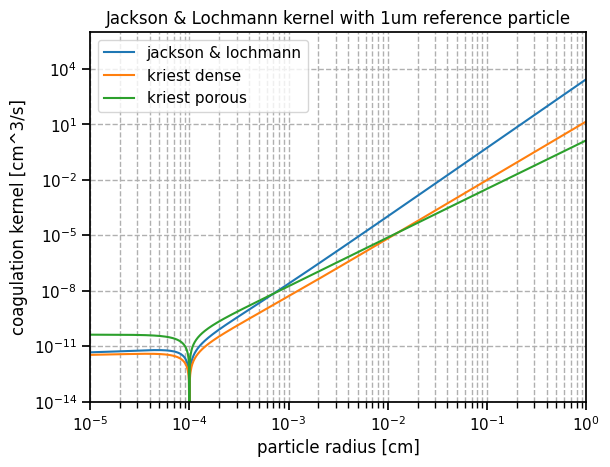

In [30]:
r_reference = 1e-6
r_test = np.linspace(1e-7,1e-2,1000000)

betas_jackson = jackson_lochmann_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_jackson = betas_jackson*1e6 # cm^3/s
betas_kriest_dense = kriest_dense_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_kriest_dense = betas_kriest_dense*1e6 # cm^3/s
betas_kriest_porous = kriest_porous_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_kriest_porous = betas_kriest_porous*1e6 # cm^3/s


plt.xscale('log')
plt.yscale('log')

plt.plot(r_test*100,betas_jackson, label='jackson & lochmann')
plt.plot(r_test*100,betas_kriest_dense, label='kriest dense')
plt.plot(r_test*100,betas_kriest_porous, label='kriest porous')

plt.xlabel('particle radius [cm]')   
plt.ylabel('coagulation kernel [cm^3/s]')
plt.title('Jackson & Lochmann kernel with 1um reference particle')
plt.ylim([1e-14,1e6])
plt.xlim([1e-5,1e0])
plt.legend()

plt.grid(which='both',linestyle='--')

plt.savefig('kernel_slices_default_vs_kriest_1um.png')

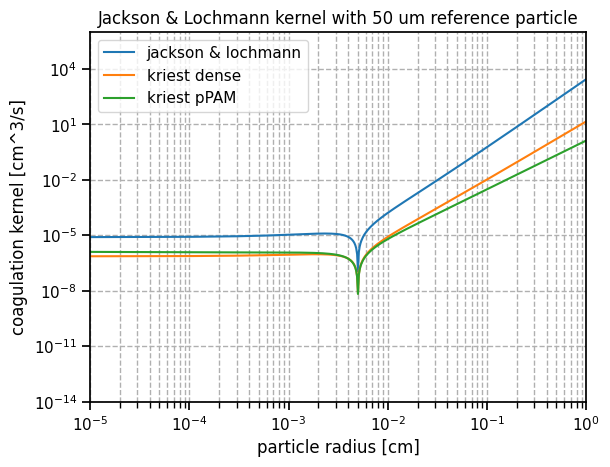

In [10]:
r_reference = 50e-6
r_test = np.linspace(1e-7,1e-2,10000)

betas_jackson = jackson_lochmann_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_jackson = betas_jackson*1e6 # cm^3/s
betas_kriest_dense = kriest_dense_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_kriest_dense = betas_kriest_dense*1e6 # cm^3/s
betas_kriest_porous = kriest_porous_kernel.evaluate_kernel(r_reference,r_test) # m^3/s
betas_kriest_porous = betas_kriest_porous*1e6 # cm^3/s


plt.xscale('log')
plt.yscale('log')

plt.plot(r_test*100,betas_jackson, label='jackson & lochmann')
plt.plot(r_test*100,betas_kriest_dense, label='kriest dense')
plt.plot(r_test*100,betas_kriest_porous, label='kriest porous')

plt.xlabel('particle radius [cm]')   
plt.ylabel('coagulation kernel [cm^3/s]')
plt.title('Jackson & Lochmann kernel with 50 um reference particle')
plt.ylim([1e-14,1e6])
plt.xlim([1e-5,1e0])
plt.legend()

plt.grid(which='both',linestyle='--')

## Looking at sinking velocities presented in Kriest

In [11]:
from coagulation_model.coagulation_kernel import coagulation_kernel as kernel
from coagulation_model.plotting_kernels import plot_kernel_map
from coagulation_model.plotting_kernels import plot_normalized_kernel_map

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('notebook')

In [12]:
kriest_dense_kernel = kernel(
    list_of_applied_kernels=[
        # 'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_kriest_dense_aggregate'
    )

jackson_lochmann_kernel = kernel(
    list_of_applied_kernels=[
        # 'rectilinear_shear',
        'rectilinear_differential_sedimentation'],
    settling_function='settling_velocity_jackson_lochmann_fractal'
    )

In [13]:
radius = np.linspace(1e-6,1e-3,100)

volume = 4/3*np.pi*radius**3

v_dense = kriest_dense_kernel.settling_velocity_kriest_dense_aggregate(volume)
v_porous = kriest_dense_kernel.settling_velocity_kriest_porous_aggregate(volume)
v_jackson = jackson_lochmann_kernel.settling_velocity_jackson_lochmann_fractal(volume)


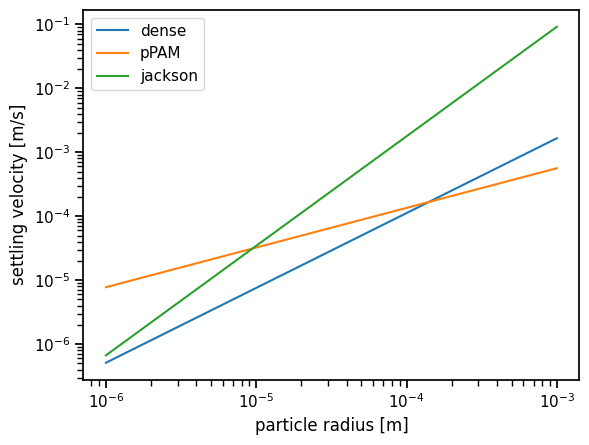

In [14]:
# plot the settling velocity

fig,ax = plt.subplots()
ax.plot(radius,v_dense, label='dense')
ax.plot(radius,v_porous, label='porous')
ax.plot(radius,v_jackson, label='jackson')
ax.set_xlabel('particle radius [m]')
ax.set_ylabel('settling velocity [m/s]')

ax.set_yscale('log')
ax.set_xscale('log')

ax.legend()

In [15]:
radius_i = np.linspace(1e-6,1e-4,100000)
radius_j = 1e-5


volume_i = 4/3*np.pi*radius_i**3
volume_j = 4/3*np.pi*radius_j**3

delta_v_kriest_dense = np.abs(
    kriest_dense_kernel.settling_velocity_kriest_dense_aggregate(volume_i) - kriest_dense_kernel.settling_velocity_kriest_dense_aggregate(volume_j)
)

delta_v_kriest_porous = np.abs(
    kriest_dense_kernel.settling_velocity_kriest_porous_aggregate(volume_i) - kriest_dense_kernel.settling_velocity_kriest_porous_aggregate(volume_j)
)


delta_v_jackson = np.abs(
    jackson_lochmann_kernel.settling_velocity_jackson_lochmann_fractal(volume_i) - jackson_lochmann_kernel.settling_velocity_jackson_lochmann_fractal(volume_j)
)


Text(0.5, 1.0, 'Coagulation kernel for 1e-5 m particle')

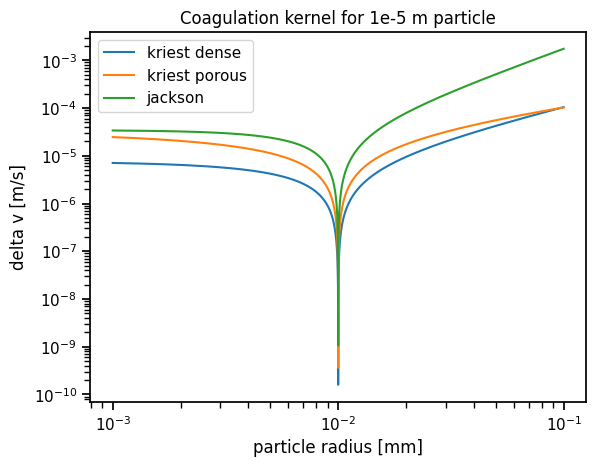

In [16]:
fig,ax = plt.subplots()
ax.plot(radius_i*1e3,delta_v_kriest_dense, label='kriest dense')
ax.plot(radius_i*1e3,delta_v_kriest_porous, label='kriest porous')
ax.plot(radius_i*1e3,delta_v_jackson, label='jackson')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('particle radius [mm]')
ax.set_ylabel('delta v [m/s]')
ax.legend()
ax.set_title('Coagulation kernel for 1e-5 m particle')

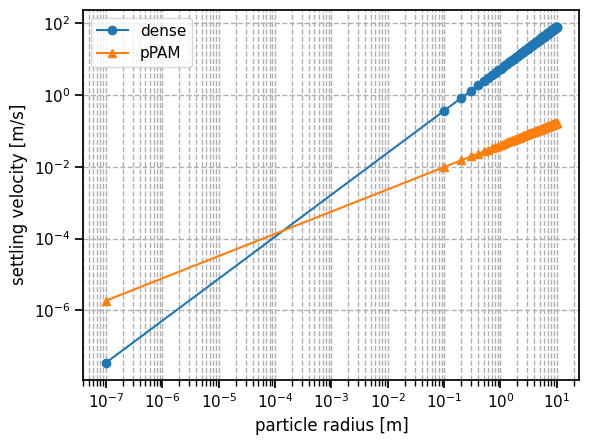

In [17]:
radius_i = np.linspace(1e-7,1e1,100) # m
volume_i = 4/3*np.pi*radius_i**3 # m**3

v_dense = kriest_dense_kernel.settling_velocity_kriest(volume_i, B = 942 , eta = 1.17)
v_porous = kriest_dense_kernel.settling_velocity_kriest(volume_i, B = 132 , eta = 0.62)

# Ref 1: 91d0:26
# v_1 = kriest_dense_kernel.settling_velocity_kriest(volume_i, B = 91, eta = 0.26) 
# v_3 = kriest_dense_kernel.settling_velocity_kriest(volume_i, B = 579, eta = 0.57) 


plt.plot(radius_i,v_dense, label='dense', marker='o')
plt.plot(radius_i,v_porous, label='porous', marker='^')
# plt.plot( radius_i, v_1, label='1: 91d^0.26', marker='o')
# plt.plot( radius_i ,v_3, label='3: 579d^0.57', marker='s')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('particle radius [m]')
plt.ylabel('settling velocity [m/s]')
# plt.xlim([0.0001,10])
# plt.ylim([0.01,10000])
plt.legend()
plt.grid(which='both',linestyle='--')

# labels in floating point notation
# from matplotlib.ticker import ScalarFormatter
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())  # Use ScalarFormatter for y-axis tick labels
# plt.gca().xaxis.set_major_formatter(ScalarFormatter())  # Use ScalarFormatter for y-axis tick labels


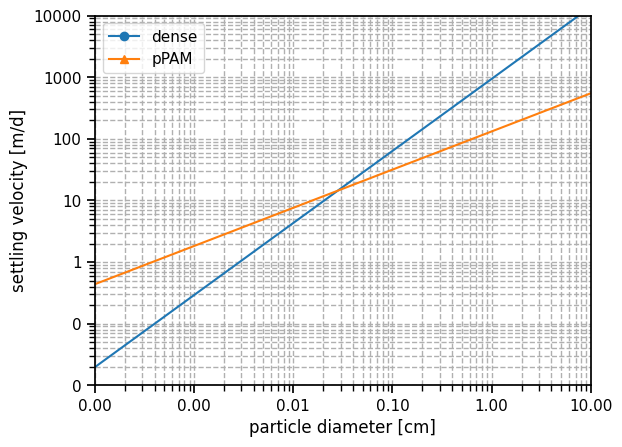

In [18]:
radius_i = np.linspace(1e-7,1e1,100) # m
volume_i = 4/3*np.pi*radius_i**3 # m**3

v_dense = kriest_dense_kernel.settling_velocity_kriest(volume_i, B = 942 , eta = 1.17)
v_porous = kriest_dense_kernel.settling_velocity_kriest(volume_i, B = 132 , eta = 0.62)

# Ref 1: 91d0:26
# v_1 = kriest_dense_kernel.settling_velocity_kriest(volume_i, B = 91, eta = 0.26) 
# v_3 = kriest_dense_kernel.settling_velocity_kriest(volume_i, B = 579, eta = 0.57) 


plt.plot(2*radius_i*100,v_dense*86400, label='dense', marker='o')
plt.plot(2*radius_i*100,v_porous*86400, label='porous', marker='^')
# plt.plot( radius_i, v_1, label='1: 91d^0.26', marker='o')
# plt.plot( radius_i ,v_3, label='3: 579d^0.57', marker='s')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('particle diameter [cm]')
plt.ylabel('settling velocity [m/d]')
plt.xlim([0.0001,10])
plt.ylim([0.01,10000])
plt.legend()
plt.grid(which='both',linestyle='--')

# labels in floating point notation
from matplotlib.ticker import ScalarFormatter
plt.gca().yaxis.set_major_formatter(ScalarFormatter())  # Use ScalarFormatter for y-axis tick labels
plt.gca().xaxis.set_major_formatter(ScalarFormatter())  # Use ScalarFormatter for y-axis tick labels
